In [ ]:
from pandas import DataFrame, read_parquet
from numpy import ndarray, nan, abs
from joblib import load
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import shap

In [2]:
def get_features_names(_, feature_names) -> ndarray:
    return feature_names

def clean_features(X: DataFrame, values: dict[str] = None, expected: bool = True):
    assert isinstance(X, DataFrame)
    assert isinstance(values, dict) or values is None 
    
    values = {
        "Housing": ["own", "rent", "free"],
        "Sex" : ["male", "female"],
        "Purpose" : [
            "car", 
            "radio/TV", 
            "furniture/equipment", 
            "business",
            "education",
            "repairs",
            "domestic appliances",
            "vacation/others"
        ]
    } if not values and expected else values
    
    categories_to_review: list[str] = list(set(X.columns).intersection(set(values.keys())))
    if len(categories_to_review) == 0: return X
    
    X[categories_to_review] = X[categories_to_review].apply(
        lambda x: x.where(x.isin(values[x.name]))
    ) if expected else X[categories_to_review].apply(
        lambda x: x.where(~x.isin(values[x.name]))
    )
    return X
    
    
def remove_outliers(X: DataFrame, threshold: float = 1.5) -> DataFrame:
    """
    Replace outliers from numeric columns given a certain treshold with NAN.
    Args:
        threshold (float, optional): Treshold for removing minor (1.5) or extreme outliers (3.0). Defaults to 1.5.
    """
    assert isinstance(X, DataFrame)
    assert 1.5 <= threshold <= 3.0
    Q1, Q3 = X.quantile(0.25), X.quantile(0.75)
    IQR: float = Q3 - Q1
    mask: function = ~((X >= (Q1 - threshold * IQR)) & (X <= (Q3 + threshold * IQR))).all(axis=1)
    X.loc[mask] = nan
    return X

In [3]:
model = load(r"../models/credit_classification-logistic_regression-v1.joblib")

In [4]:
coef_interpretation = DataFrame({
    "features": model["preprocessor"].get_feature_names_out(),
    "importance": abs(model["model"].coef_[0])
}).sort_values("importance", ascending=False)

In [5]:
credit_df = read_parquet(r"../data/types_fixed_german_credit_data.parquet", engine="pyarrow")
credit_features = credit_df.drop_duplicates(subset=["Unnamed: 0"])

selected_features: list[str] = ['Credit amount', 'Purpose', 'Job', 'Sex', 'Saving accounts', 'Housing', 'Risk', 'Age']
credit_features: DataFrame = credit_features[selected_features]

credit_features: DataFrame = credit_features.dropna(subset=["Risk"])
credit_features["Risk"] = credit_features["Risk"].map({"good": 1, "bad" : 0})

In [6]:
X_features = credit_features.drop("Risk", axis="columns")
Y_target = credit_features["Risk"]

# 80% train, 20% test
x_train, x_test, y_train, y_test = train_test_split(
    X_features, Y_target, test_size=0.2, stratify=Y_target
)

Text(0.5, 1.0, 'Permutation Importances (test set)')

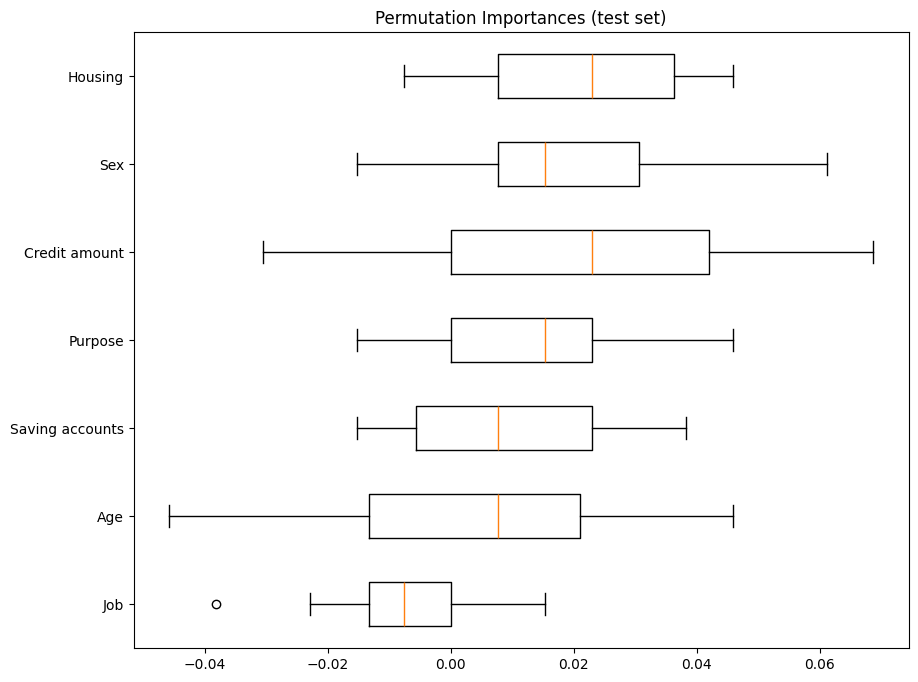

In [7]:
imps = permutation_importance(
    model, x_test, y_test, scoring="recall", n_repeats=30, random_state=42, n_jobs=8
)

fig = plt.figure(figsize=(10, 8))
perm_sorted_idx = imps.importances_mean.argsort()
plt.boxplot(
    imps.importances[perm_sorted_idx].T, vert=False, tick_labels=x_test.columns[perm_sorted_idx]
)
plt.title("Permutation Importances (test set)")

In [8]:
x = model["preprocessor"].transform(x_train)

explainer = shap.KernelExplainer(
    model["model"].predict,
    shap.sample(x, 100)
)

shap_values: ndarray = explainer.shap_values(x)

shap_interpretation = DataFrame(
    data= shap_values,
    columns= model["preprocessor"].get_feature_names_out()
)

  0%|          | 0/748 [00:00<?, ?it/s]

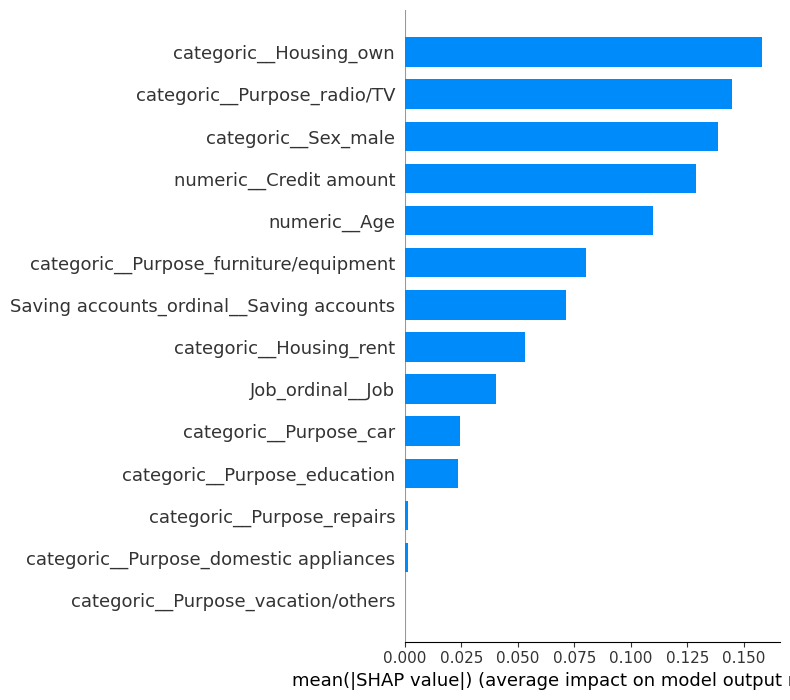

In [9]:
shap.summary_plot(
    shap_values,
    shap_interpretation,
    feature_names = shap_interpretation.columns,
    plot_type = "bar"
)

In [30]:
coef_interpretation

,features,importance
12,Saving accounts_ordinal__Saving accounts,0.640026
9,categoric__Housing_own,0.620786
6,categoric__Purpose_radio/TV,0.584960
11,categoric__Sex_male,0.464804
5,categoric__Purpose_furniture/equipment,0.377815
10,categoric__Housing_rent,0.307604
4,categoric__Purpose_education,0.273312
13,Job_ordinal__Job,0.110719
2,categoric__Purpose_car,0.066381
1,numeric__Age,0.019344


# Analysis of results
## Which are the most important features?
Analyzing the results shown by the coefficients Dataframe and shap values anlysis, it seems that all features aside from Job are important for the model outcome.
## How much is each feature contributing to the prediction?
Shap values analysis and the coefficients DataFrame give a clear insight into each feature contribution to the models prediction.
## Which are the consecuences of bad predictions?
Bad predictions are either False Positives (FP) or False Negatives (FN). In case of False Positivies the model would be categorizing bad credit as good risk **allowing a potential bad client**, for the other escenario, the model the model would be categorizing good credit as bad risk **missing a potential good client**.
## What type of mistakes does the model take uppon?
As shown in the Logistic Regression model selection confusion matrix, the model is falling into FP and FN, but most of the errors are FP which is problematic.
## What is the reason for those mistakes to happen?
...
